# Importing 

In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
from BaseNetwork import BaseNetwork
from torch.nn import L1Loss
from torch.optim import Adam, lr_scheduler
import numpy as np
from FNN import FNN
from Seq2Seq import Seq2Seq
import pandas as pd

%load_ext autoreload
%autoreload 2

# Load Data

### The data is loaded twice: With/without time of day

In [2]:
previous_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        timeofday = True)
train2 = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        )

validation = MoviaBusDataset('../data/validation', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)
validation2 = MoviaBusDataset('../data/validation', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps)

test = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)
test2 = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps)


# Historical average

In [4]:
train_his_mean = pd.concat(train.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
train_his_mean = train_his_mean.pivot(index='Time', columns='LinkRef',values='Speed').groupby(['TimeOfDay']).mean()

validation_his_mean = pd.concat(validation.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
validation_his_mean = validation_his_mean.pivot(index='Time', columns='LinkRef',values='Speed')

n_valdays = 2
n_measure = int(len(validation_his_mean)/n_valdays)
valday1 = validation_his_mean[0*n_measure:1*n_measure].groupby(['TimeOfDay']).mean()
valday2 = validation_his_mean[1*n_measure:2*n_measure].groupby(['TimeOfDay']).mean()

test_his_mean = pd.concat(test.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
test_his_mean = test_his_mean.pivot(index='Time', columns='LinkRef',values='Speed')

n_testdays = 3
n_measure = int(len(test_his_mean)/n_testdays)
testday1 = test_his_mean[0*n_measure:1*n_measure].groupby(['TimeOfDay']).mean()
testday2 = test_his_mean[1*n_measure:2*n_measure].groupby(['TimeOfDay']).mean()
testday3 = test_his_mean[2*n_measure:3*n_measure].groupby(['TimeOfDay']).mean()

MAE_his_average = np.mean([abs(testday1-train_his_mean).mean().mean(),abs(testday2-train_his_mean).mean().mean(),
                           abs(testday3-train_his_mean).mean().mean(),abs(valday1-train_his_mean).mean().mean(),
                           abs(valday2-train_his_mean).mean().mean()])
print('Mean Absolute Error: ',MAE_his_average) 

Mean Absolute Error:  1.5855474700159466


# Pre-modelling 

In [5]:
#The training set is reorganized such that it easlily can be used for computing the historical mean 
train_all = pd.concat(train.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
train_road_mean = train_all.pivot(index='Time', columns='LinkRef',values='Speed').groupby(['TimeOfDay']).mean()

#Removing trend 
train.remove_trend()
validation.remove_trend(train._historical_average)
test.remove_trend(train._historical_average)

train2.remove_trend()
validation2.remove_trend(train2._historical_average)
test2.remove_trend(train2._historical_average)

#Normalize the data-set wihtout the time-of-day parameter 
train2.normalize(individual_roads=False)
validation2.normalize(train2.mean, train2.std)
test2.normalize(train2.mean, train2.std)

# FNN 

epoch =  0  train loss = 1.404   validation loss = 1.532   output_std = 0.553
Model saved as FNN.pt
epoch =  2  train loss = 1.392   validation loss = 1.526   output_std = 0.727
Model saved as FNN.pt
epoch =  4  train loss = 1.391   validation loss = 1.524   output_std = 0.707
Model saved as FNN.pt
epoch =  6  train loss = 1.389   validation loss = 1.524   output_std = 0.712
Model saved as FNN.pt
epoch =  8  train loss = 1.389   validation loss = 1.523   output_std = 0.721
Model saved as FNN.pt
epoch = 10  train loss = 1.388   validation loss = 1.523   output_std = 0.737
Model saved as FNN.pt
epoch = 12  train loss = 1.388   validation loss = 1.522   output_std = 0.748
Model saved as FNN.pt
epoch = 14  train loss = 1.388   validation loss = 1.522   output_std = 0.746
Model saved as FNN.pt
epoch = 16  train loss = 1.387   validation loss = 1.522   output_std = 0.744
Model saved as FNN.pt
epoch = 18  train loss = 1.387   validation loss = 1.522   output_std = 0.743
epoch = 20  train loss

<IPython.core.display.Javascript object>


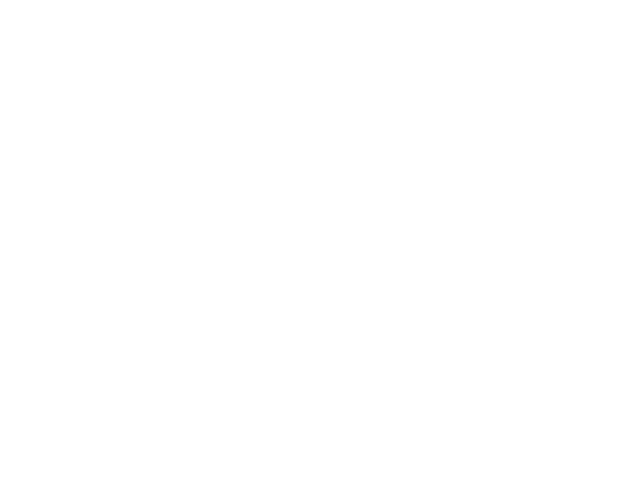

In [6]:
net_FNN = FNN(num_hidden=20)

optimizer_fun = lambda param : Adam(param, lr=1e-2, weight_decay=0)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=25, gamma=0.1)
criterion = L1Loss()

net_FNN.train_network(train, validation,batch_size=batch_size, 
                  num_epochs=50,
                  optimizer_fun=optimizer_fun,
                  scheduler_fun=scheduler_fun,
                  criterion=criterion)

validation_scores=[net_FNN.get_MAE_score(validation,timestep=i) for i in range(1,prediction_steps+1)]
print('Validation score:\n',validation_scores)
print('\nMean validation score for all timesteps:\n',sum(validation_scores)/len(validation_scores))

test_scores=[net_FNN.get_MAE_score(test,timestep=i) for i in range(1,prediction_steps+1)]
print('\nTest score:\n',test_scores)
print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

%matplotlib notebook
net_FNN.visualize_road(test, timesteps=6, road=16)

# Sequence2Sequence 

epoch =  0  train loss = 0.708   validation loss = 0.797   output_std = 0.223
Model saved as Sequence2Sequence.pt
epoch =  2  train loss = 0.676   validation loss = 0.789   output_std = 0.286
Model saved as Sequence2Sequence.pt
epoch =  4  train loss = 0.659   validation loss = 0.790   output_std = 0.313
epoch =  6  train loss = 0.648   validation loss = 0.795   output_std = 0.327
epoch =  8  train loss = 0.639   validation loss = 0.795   output_std = 0.341
Validation score:
 [1.5211817026138306, 1.5267927646636963, 1.5292035341262817, 1.5324158668518066, 1.5374499559402466, 1.5411033630371094]

Mean validation score for all timesteps:
 1.5313578645388286

Test score:
 [1.520180344581604, 1.520344614982605, 1.5222156047821045, 1.523577332496643, 1.5270729064941406, 1.529802918434143]

Mean test score for all timesteps:
 1.5238656202952068


<IPython.core.display.Javascript object>


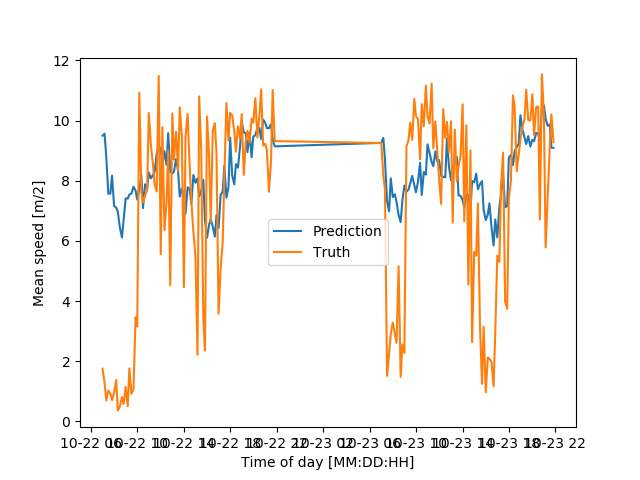

In [10]:
net_s2s = Seq2Seq()

optimizer_fun = lambda param : Adam(param, lr=1e-3, weight_decay=1e-4)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
criterion = L1Loss()

net_s2s.train_network(train2, validation2 ,batch_size=10, 
                  num_epochs=10,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  criterion=criterion,
                  shuffle=True,
                 target_to_net=True)

net_s2s._BaseNetwork__target_to_net = True

validation_scores=[net_s2s.get_MAE_score(validation2,timestep=i) for i in range(1,prediction_steps+1)]
print('Validation score:\n',validation_scores)
print('\nMean validation score for all timesteps:\n',sum(validation_scores)/len(validation_scores))

test_scores=[net_s2s.get_MAE_score(test2,timestep=i) for i in range(1,prediction_steps+1)]
print('\nTest score:\n',test_scores)
print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

%matplotlib notebook
net_s2s.visualize_road(validation2,timesteps=6, road=16)

# DCRNN